# Compare calculation of E data from an electric dipole using the cyl mesh

The goal here is to compare the 2D and 3D cylindrical solutions against the analytic solution for an electric dipole and to examine the impact of the different formulations E-B vs H-J on the solution

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0

# SimPEG and discretize
from SimPEG.EM import FDEM
from SimPEG import Utils, Maps
import discretize
from discretize import utils
from pymatsolver import Pardiso

# casing utilities
import casingSimulations

%matplotlib inline

In [2]:
from SimPEG.EM import Analytics

In [30]:
# conductivity of the wholespace

sigma_back = 1e-1
freqs = np.r_[1, 10]

print(500./np.sqrt(sigma_back * freqs))

[ 1581.13883008   500.        ]


In [47]:
csx, ncx, npadx = 1, 20, 23
ncy = 16
csz, ncz, npadz = 1, 20, 23

hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.3)])
hy = 2*np.pi / ncy * np.ones(ncy)
hz = Utils.meshTensor([(csz, npadz, -1.3), (csz, ncz), (csz, npadz, 1.3)])

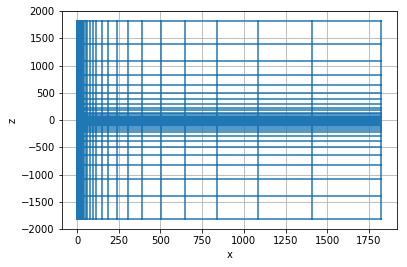

In [48]:
mesh2D = discretize.CylMesh([hx, 1., hz], x0='00C')
mesh2D.plotGrid()

In [49]:
mesh3D = discretize.CylMesh([hx, hy, hz], x0='00C')

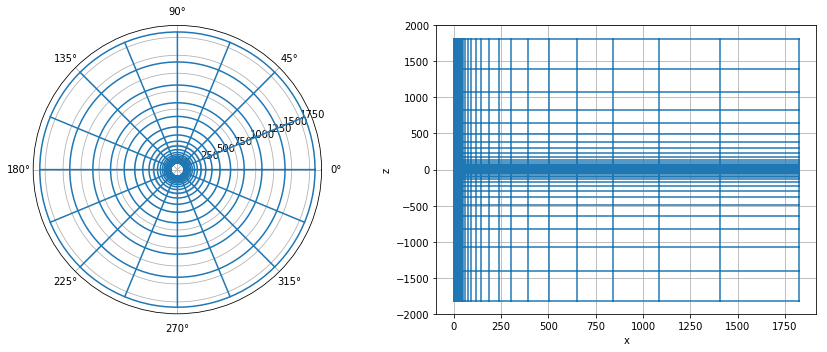

In [50]:
mesh3D.plotGrid()

In [51]:
# put the source at the center

def getFaceSrc(mesh):

    srcInd = (
        (mesh.gridFz[:,0] < csx) &
        (mesh.gridFz[:,2] < csz/2.) & (mesh.gridFz[:,2] > -csz/2.)
    )
    
    src_vecz = np.zeros(mesh.nFz, dtype=complex)
    src_vecz[srcInd] = 1.
    
    return np.hstack([np.zeros(mesh.vnF[:2].sum(), dtype=complex), src_vecz])

In [52]:
s_e2D = getFaceSrc(mesh2D)
s_e3D = getFaceSrc(mesh3D)

In [53]:
# set up the src list
srcList2D = [FDEM.Src.RawVec_e([], f, s_e2D) for f in freqs]
srcList3D = [FDEM.Src.RawVec_e([], f, s_e3D) for f in freqs]

In [54]:
prob2D = FDEM.Problem3D_h(mesh2D, sigmaMap=Maps.IdentityMap(mesh2D), Solver=Pardiso)
prob3D = FDEM.Problem3D_h(mesh3D, sigmaMap=Maps.IdentityMap(mesh3D), Solver=Pardiso)

survey2D = FDEM.Survey(srcList2D)
survey3D = FDEM.Survey(srcList3D)

prob2D.pair(survey2D)
prob3D.pair(survey3D)

In [55]:
%%time

fields2D = prob2D.fields(sigma_back*np.ones(mesh2D.nC))

CPU times: user 73.2 ms, sys: 5.56 ms, total: 78.8 ms
Wall time: 52 ms


In [56]:
%%time

fields3D = prob3D.fields(sigma_back*np.ones(mesh3D.nC))

CPU times: user 1min 39s, sys: 2.8 s, total: 1min 42s
Wall time: 58.1 s


# plot the current density

In [57]:
def getj3Dplot(j3D, theta_ind=0):
    j3D_x = j3D[:mesh3D.nFx].reshape(mesh3D.vnFx, order='F')
    j3D_z = j3D[mesh3D.vnF[:2].sum():].reshape(mesh3D.vnFz, order='F')
    
    j3Dplt = np.vstack([utils.mkvc(j3D_x[:,theta_ind,:],2), utils.mkvc(j3D_z[:,theta_ind,:],2)])
    
    return j3Dplt

In [58]:
freq_plt = 1

j2D = fields2D[srcList2D[freq_plt], 'j']
j3D = fields3D[srcList3D[freq_plt], 'j']

j3Dplt = getj3Dplot(j3D)

In [59]:
def plotJcomparison(j1, j2, real_or_imag='real', ax=None):
    if len(j1) == mesh2D.nF:
        vType = 'F'
    elif len(j1) == mesh2D.nC*2:
        vType = 'CCv'
    
    if ax is None:
        fig, ax = plt.subplots(1,3, figsize=(10, 4))

    plt.colorbar(
    mesh2D.plotImage(
            getattr(j1, real_or_imag), view='vec', vType=vType, ax=ax[0], range_x=np.r_[-50, 50], range_y=np.r_[-50., 50.], mirror=True, 
            pcolorOpts={
                'norm':LogNorm()
            },
        )[0], ax=ax[0]
    )

    plt.colorbar(
        mesh2D.plotImage(
            getattr(j2, real_or_imag), view='vec', vType=vType, ax=ax[1], range_x=np.r_[-50, 50], range_y=np.r_[-50., 50.], mirror=True, 
            pcolorOpts={
                'norm':LogNorm()
            },
        )[0], ax=ax[1]
    )


    plt.colorbar(
        mesh2D.plotImage(
            getattr((j1 - j2), real_or_imag), view='vec', vType=vType, ax=ax[2], range_x=np.r_[-50, 50], range_y=np.r_[-50., 50.], mirror=True, 
             pcolorOpts={'norm':LogNorm()
            },
        )[0], ax=ax[2]
    )

    plt.tight_layout()

# Compare current density with analytic

In [60]:
eana_x, _, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridFx, np.r_[0., 0., 0.], sig=sigma_back, f=np.r_[freqs[freq_plt]], current=csx**2 * np.pi, 
    length=1., orientation='Z'
)
_, _, eana_z = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridFz, np.r_[0., 0., 0.], sig=sigma_back, f=np.r_[freqs[freq_plt]], current=csx**2 * np.pi, 
    length=1., orientation='Z'
)
eana = utils.mkvc(np.hstack([eana_x, eana_z]),2)
jana = sigma_back * eana

eccx, _, eccz = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridCC, np.r_[0., 0., 0.], sig=sigma_back, f=np.r_[freqs[freq_plt]], current=csx**2 * np.pi, 
    length=1., orientation='Z'    
)

ecc_ana = utils.mkvc(np.hstack([eccx, eccz]),2)

Text(0.5,1,u'difference')

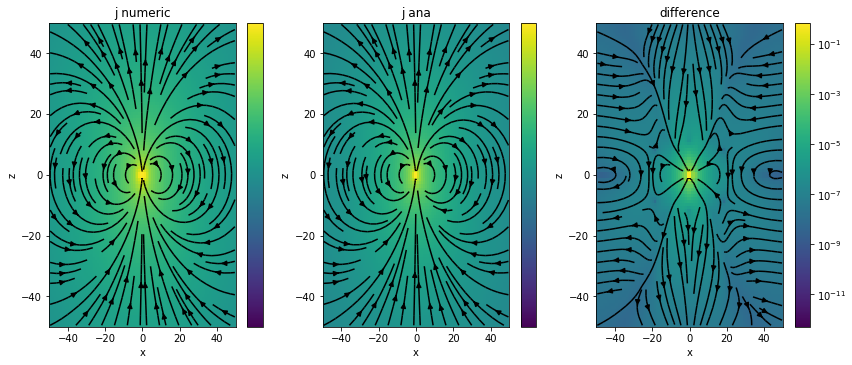

In [61]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))

plotJcomparison(j3Dplt, jana, ax=ax, real_or_imag='real')

ax[0].set_title('j numeric')
ax[1].set_title('j ana')
ax[2].set_title('difference')

# Look at electric fields

In [24]:
e3D = fields3D[srcList3D[freq_plt], 'e']
e2D = fields2D[srcList2D[freq_plt], 'e']

In [25]:
len(e3D) / mesh3D.nC

3

In [26]:
def gete3Dplot(e3D, theta_ind=0):
    e3D_x = e3D[:mesh3D.nC].reshape(mesh3D.vnC, order='F')
    e3D_z = e3D[mesh3D.nC*2:].reshape(mesh3D.vnC, order='F')
    
    e3Dplt = np.vstack([utils.mkvc(e3D_x[:,theta_ind,:],2), utils.mkvc(e3D_z[:,theta_ind,:],2)])
    
    return e3Dplt

In [23]:
e3Dplt = gete3Dplot(e3D)

ValueError: cannot reshape array of size 121200 into shape (60,20,100)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))

plotJcomparison(e3Dplt, ecc_ana, ax=ax, real_or_imag='imag')

ax[0].set_title('e num')
ax[1].set_title('e ana')
ax[2].set_title('diff')

plt.tight_layout()

In [ ]:
# line plots
e3D_x = e3Dplt[:mesh2D.nC].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')
e3D_z = e3Dplt[mesh2D.nC:].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')

e2D_x = e2D[:mesh2D.nC].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')
e2D_z = e2D[mesh2D.nC:].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')

eana_x = ecc_ana[:mesh2D.nC].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')
eana_z = ecc_ana[mesh2D.nC:].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')

In [ ]:
def plot_lines(x, e2D=None, e3D=None, eana=None, xlim=[0., 100.], name=None):
    fig, ax = plt.subplots(3, 2, figsize=(12,8))
    ax = utils.mkvc(ax)
    
    plt_ind = (x > xlim[0]) & (x < xlim[1])
    
    x = x[plt_ind]
    if e2D is not None: e2D = e2D[plt_ind]
    if e3D is not None: e3D = e3D[plt_ind]
    if eana is not None: eana = eana[plt_ind]
    
    # Plot real
    if any(eana.real > 0): 
        if e2D is not None: ax[0].semilogy(x, e2D.real, '-b', label='2D')
        if e3D is not None: ax[0].semilogy(x, e3D.real, '-g', label='3D')
        if eana is not None: ax[0].semilogy(x, eana.real, '-r', label='ana')
    if any(eana.real < 0): 
        if e2D is not None: ax[0].semilogy(x, -e2D.real, '--b', label='2D')
        if e3D is not None: ax[0].semilogy(x, -e3D.real, '--g', label='3D')
        if eana is not None: ax[0].semilogy(x, -eana.real, '--r', label='ana')
        
    ax[0].set_xlim(xlim)
    ax[0].set_title('{} real'.format(name))
    ax[0].legend()


    if e2D is not None: ax[1].semilogy(x, np.absolute(e2D.real - eana.real), '-b', label='2D')
    if e3D is not None: ax[1].semilogy(x, np.absolute(e3D.real - eana.real), '-g', label='3D')

    ax[1].set_xlim(xlim)
    ax[1].set_title('{} error real'.format(name))
    ax[1].legend()

    if e2D is not None: ax[2].plot(
        x, (e2D.real - eana.real)/(eana.real), '-b', label='2D'
    )
    if e3D is not None: ax[2].plot(
        x, (e3D.real - eana.real)/(eana.real), '-g', label='3D'
    )

    ax[2].set_xlim(xlim)
    ax[2].set_ylim(0.05*np.r_[-1, 1])
    ax[2].set_title('{} error real'.format(name))
    ax[2].legend()

    if any(eana.imag > 0):
        if e2D is not None: ax[3].semilogy(x, e2D.imag, '-b', label='2D')
        if e3D is not None: ax[3].semilogy(x, e3D.imag, '-g', label='3D')
        ax[3].semilogy(x, eana.imag, '-r', label='ana')
    if any(eana.imag < 0): 
        if e2D is not None: ax[3].semilogy(x, -e2D.imag, '--b', label='2D')
        if e3D is not None: ax[3].semilogy(x, -e3D.imag, '--g', label='3D')
        ax[3].semilogy(x, -eana.imag, '--r', label='ana')
        
    ax[3].set_title('{} imag'.format(name))
    ax[3].set_xlim(xlim)
    ax[3].legend()

    if e2D is not None: ax[4].semilogy(x, np.absolute(e2D.imag - eana.imag), '-b', label='2D')
    if e3D is not None: ax[4].semilogy(x, np.absolute(e3D.imag - eana.imag), '-g', label='3D')

    ax[4].set_xlim(xlim)
    ax[4].set_title('{} error imag'.format(name))
    ax[4].legend()

    if e2D is not None: ax[5].plot(
        x, (e2D.imag - eana.imag)/(eana.imag), '-b', label='2D'
    )
    if e3D is not None: ax[5].plot(
        x, (e3D.imag - eana.imag)/(eana.imag), '-g', label='3D'
    )

    ax[5].set_xlim(xlim)
    ax[5].set_ylim(0.05*np.r_[-1, 1])
    ax[5].set_title('{} error imag'.format(name))
    ax[5].legend()
    
    plt.tight_layout()
    
    return fig, ax

    

In [ ]:
z_ind = mesh2D.vnC[2]/2 + 10
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(mesh2D.vectorCCx, e2D_x[:, z_ind], e3D_x[:, z_ind], eana_x[:, z_ind], xlim=[0., 100.], name='Ex')

In [ ]:
z_ind = mesh2D.vnC[2]/2 + 10
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(mesh2D.vectorCCx, e2D_z[:, z_ind], e3D_z[:, z_ind], eana_z[:, z_ind], xlim=[0., 100.], name='Ez')

In [ ]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(mesh2D.vectorCCz, e2D_x[x_ind, :], e3D_x[x_ind, :], eana_x[x_ind, :], xlim=[-100., 100.], name='Ex')

In [ ]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(mesh2D.vectorCCz, e2D_z[x_ind, :], e3D_z[x_ind, :], eana_z[x_ind, :], xlim=[-100., 100.], name='Ez')

# edge source with e-b formulation for 3D mesh

E-B is the "wrong" symmetry to employ for this simulation, thus we expect that in order to achieve the same level of accuracy as the HJ simulation (the correct symmetry to employ for an electric dipole) would require a more refined mesh. Here we examine the impact of that assumption on our recovered results.  

In [ ]:
srcInd = (
    (mesh3D.gridEz[:,0] < csx/2.) &
    (mesh3D.gridEz[:,2] < csz/2.) & (mesh3D.gridEz[:,2] > -csz/2.)
)

src_vecz = np.zeros(mesh3D.nEz, dtype=complex)
src_vecz[srcInd] = 1.

src_vec = np.hstack([np.zeros(mesh3D.vnE[:2].sum(), dtype=complex), src_vecz])

In [ ]:
srcLoc = mesh3D.gridEz[srcInd, :]
print srcLoc

In [ ]:
edgeSrcList = [FDEM.SrcFDEM.RawVec_e([], f, src_vec) for f in freqs]

In [ ]:
prb3D_e = FDEM.Problem3D_e(mesh3D, sigmaMap=Maps.IdentityMap(mesh3D), Solver=Pardiso)
survey3D_e = FDEM.Survey(edgeSrcList)

prb3D_e.pair(survey3D_e)

In [ ]:
%%time
fields3D_e = prb3D_e.fields(sigma_back*np.ones(mesh3D.nC))

In [ ]:
freq_plt = 1
e3D_cc = mesh3D.aveE2CCV * fields3D_e[edgeSrcList[freq_plt], 'e']
e3D_ccplt = gete3Dplot(e3D_cc)

In [ ]:
eccx, _, eccz = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridCC, utils.mkvc(srcLoc), sig=sigma_back, f=np.r_[freqs[freq_plt]], current=1., 
    length=1., orientation='Z'    
)

eccE_ana = utils.mkvc(np.hstack([eccx, eccz]), 2)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
plotJcomparison(e3D_ccplt, eccE_ana, ax=ax, real_or_imag='real')

In [43]:
print(e3DE.shape, mesh3D.nE, mesh3D.nF) 

((362500, 1), 362500, 361200)


In [47]:
e3DE = fields3D_e[edgeSrcList[freq_plt], 'e']
e3DE_x = j3D[:mesh3D.nEx].reshape(mesh3D.vnEx, order='F')
e3DE_z = j3D[mesh3D.vnE[:2].sum():] #.reshape(mesh3D.vnEz, order='F')

XYZ_x = utils.ndgrid(mesh3D.vectorCCx, np.r_[0.], mesh3D.vectorNz)
eanaE_x, _, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    XYZ_x, utils.mkvc(srcLoc)+ np.ones(3)*1e-12, sig=sigma_back, f=np.r_[freqs[freq_plt]], current=1./np.pi, 
    length=csz, orientation='Z'    
)


XYZ_z = utils.ndgrid(mesh3D.vectorNx, np.r_[0.], mesh3D.vectorCCz)
_, _, eanaE_z = Analytics.E_from_ElectricDipoleWholeSpace(
    XYZ_z, utils.mkvc(srcLoc)+ np.ones(3)*1e-12, sig=sigma_back, f=np.r_[freqs[freq_plt]], current=1./np.pi, 
    length=csz, orientation='Z'    
)

eanaE_x = eanaE_x.reshape([mesh3D.vnEx[0], mesh3D.vnEx[2]], order='F')
eanaE_z = eanaE_z.reshape([mesh3D.vnN[0], mesh3D.vnC[2]], order='F')

looking at z=0.500000000002


(-0.3, 0.0)

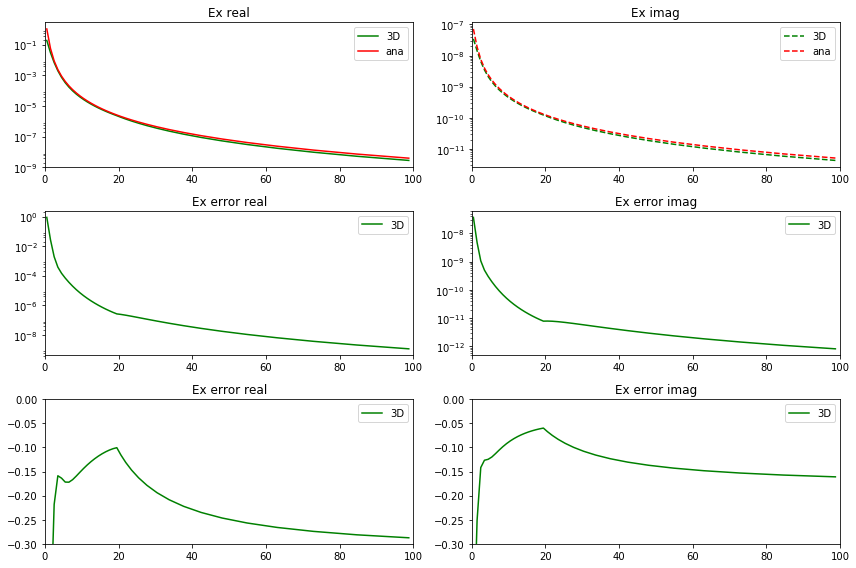

In [48]:
z_ind = mesh3D.vnC[2]/2 
print('looking at z={}'.format(mesh3D.vectorCCz[z_ind]))

fig, ax = plot_lines(mesh3D.vectorCCx, None, e3DE_x[:, 0, z_ind], eanaE_x[:, z_ind], xlim=[0., 100.], name='Ex')
ax[2].set_ylim([-0.3, 0.])
ax[5].set_ylim([-0.3, 0.])

looking at z=2.5


(-1.0, 1.0)

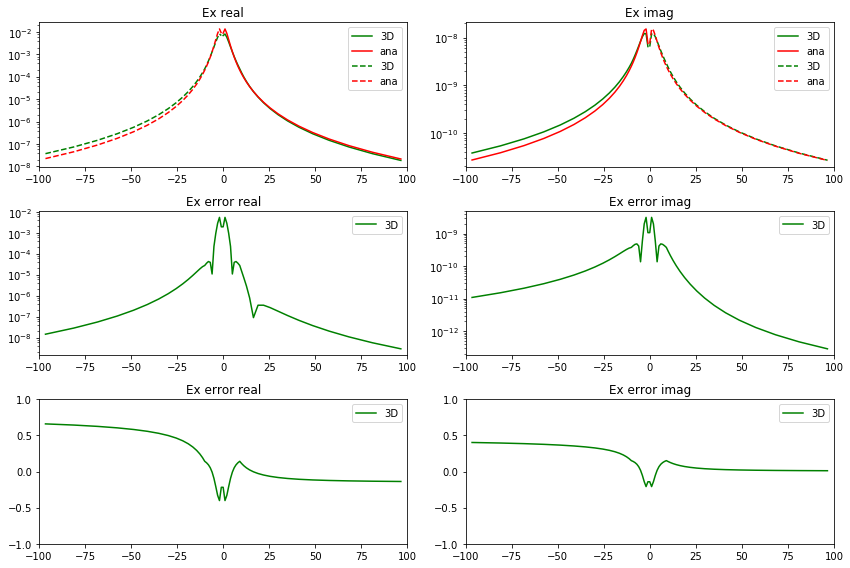

In [49]:
x_ind = 2
print('looking at z={}'.format(mesh3D.vectorCCx[x_ind]))

fig, ax = plot_lines(mesh3D.vectorNz, None, e3DE_x[x_ind, 0, :], eanaE_x[x_ind, :], xlim=[-100., 100.], name='Ex')
ax[2].set_ylim([-1., 1.])
ax[5].set_ylim([-1., 1.])

In [50]:
np.linalg.norm(e3DE_x[:,0,:])

0.28822465946146725

In [51]:
np.linalg.norm(e3DE_x[:,0,:])

0.28822465946146725